In [1]:
%matplotlib nbagg

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

Hardware information:
```
Model name:          Intel(R) Xeon(R) CPU E3-1505M v5 @ 2.80GHz
Thread(s) per core:  2
Core(s) per socket:  4
Socket(s):           1
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            8192K
```

In [42]:
import numpy as np
np.show_config()

blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/lib/x86_64-linux-gnu']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/lib/x86_64-linux-gnu']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/lib/x86_64-linux-gnu']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/lib/x86_64-linux-gnu']
    language = c
    define_macros = [('HAVE_CBLAS', None)]


OpenBLAS version:
```
$ dpkg -l libopenblas-base
ii  libopenblas-base:amd64   0.2.20+ds-4       amd64             Optimized BLAS (linear algebra) library (shared libra
```

In [3]:
import gc
import time
import seaborn
import pandas as pd
import matplotlib.pyplot as plt
from libertem.dataset.hdf5 import H5DataSet
from libertem.dataset.hdfs import BinaryHDFSDataSet
from libertem.executor.dask import DaskJobExecutor
from libertem.job.masks import ApplyMasksJob

/home/clausen/.virtualenvs/libertem/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
def make_masks(n=5, shape=(128, 128)):
    masks=[
        np.random.randn(*shape)
        for i in range(n)
    ]
    return masks

In [5]:
executor = DaskJobExecutor.make_local(cluster_kwargs={"threads_per_worker": 1, "n_workers": 1})

masks = make_masks(n=16)

def process_with_params(num_masks, stackheight):
    ds = BinaryHDFSDataSet(index_path="test/index.json", host='localhost', port=8020, stackheight=stackheight)
    job = ApplyMasksJob(dataset=ds, masks=masks[:num_masks])
    for result in executor.run_job(job):
        for tile in result:
            pass
    # TODO: ds.close()

In [7]:
%time process_with_params(num_masks=1, stackheight=8)

CPU times: user 239 ms, sys: 20.6 ms, total: 259 ms
Wall time: 1.62 s


In [8]:
results = []
for n_workers in range(1, 9):
    cluster = executor.client.cluster
    cluster.scale_up(n_workers, ncores=1)
    for num_masks in [1, 2, 4, 8, 16]:
        for stackheight in [4, 8]:
            for repeat in range(3):
                gc.collect()
                t0 = time.time()
                process_with_params(num_masks=num_masks + 1, stackheight=stackheight)
                t1 = time.time()
                result = {
                    "num_masks": num_masks,
                    "n_workers": n_workers,
                    "stackheight": stackheight,
                    "time": t1 - t0,
                }
                results.append(result)
                print(result)

{'num_masks': 1, 'n_workers': 1, 'stackheight': 4, 'time': 2.5112760066986084}
{'num_masks': 1, 'n_workers': 1, 'stackheight': 4, 'time': 2.5613961219787598}
{'num_masks': 1, 'n_workers': 1, 'stackheight': 4, 'time': 2.5959901809692383}
{'num_masks': 1, 'n_workers': 1, 'stackheight': 8, 'time': 2.420463800430298}
{'num_masks': 1, 'n_workers': 1, 'stackheight': 8, 'time': 2.3649823665618896}
{'num_masks': 1, 'n_workers': 1, 'stackheight': 8, 'time': 2.351158618927002}
{'num_masks': 2, 'n_workers': 1, 'stackheight': 4, 'time': 2.878171920776367}
{'num_masks': 2, 'n_workers': 1, 'stackheight': 4, 'time': 2.8866357803344727}
{'num_masks': 2, 'n_workers': 1, 'stackheight': 4, 'time': 2.8992886543273926}
{'num_masks': 2, 'n_workers': 1, 'stackheight': 8, 'time': 2.6457021236419678}
{'num_masks': 2, 'n_workers': 1, 'stackheight': 8, 'time': 2.6181726455688477}
{'num_masks': 2, 'n_workers': 1, 'stackheight': 8, 'time': 2.6292998790740967}
{'num_masks': 4, 'n_workers': 1, 'stackheight': 4, 'tim

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 2, 'stackheight': 8, 'time': 2.544952869415283}
{'num_masks': 16, 'n_workers': 2, 'stackheight': 8, 'time': 2.5448381900787354}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 3, 'stackheight': 4, 'time': 1.2036759853363037}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 3, 'stackheight': 4, 'time': 1.1363344192504883}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 3, 'stackheight': 4, 'time': 1.1512782573699951}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 3, 'stackheight': 8, 'time': 1.1155593395233154}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 3, 'stackheight': 8, 'time': 1.0951638221740723}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 3, 'stackheight': 8, 'time': 1.1112749576568604}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 3, 'stackheight': 4, 'time': 1.2624213695526123}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 3, 'stackheight': 4, 'time': 1.3265480995178223}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 3, 'stackheight': 4, 'time': 1.3262715339660645}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 3, 'stackheight': 8, 'time': 1.2039587497711182}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 3, 'stackheight': 8, 'time': 1.2509346008300781}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 3, 'stackheight': 8, 'time': 1.2447514533996582}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 3, 'stackheight': 4, 'time': 1.442671298980713}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 3, 'stackheight': 4, 'time': 1.4463541507720947}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 3, 'stackheight': 4, 'time': 1.4263036251068115}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 3, 'stackheight': 8, 'time': 1.3725650310516357}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 3, 'stackheight': 8, 'time': 1.3312547206878662}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 3, 'stackheight': 8, 'time': 1.331780195236206}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 3, 'stackheight': 4, 'time': 1.8667521476745605}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 3, 'stackheight': 4, 'time': 1.9053680896759033}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 3, 'stackheight': 4, 'time': 1.8356788158416748}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 3, 'stackheight': 8, 'time': 1.5969922542572021}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 3, 'stackheight': 8, 'time': 1.5633680820465088}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 3, 'stackheight': 8, 'time': 1.5516297817230225}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 3, 'stackheight': 4, 'time': 2.595517635345459}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 3, 'stackheight': 4, 'time': 2.606764793395996}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 3, 'stackheight': 4, 'time': 2.621882915496826}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 3, 'stackheight': 8, 'time': 2.0675206184387207}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 3, 'stackheight': 8, 'time': 2.019901752471924}
{'num_masks': 16, 'n_workers': 3, 'stackheight': 8, 'time': 2.0107345581054688}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 4, 'stackheight': 4, 'time': 0.9980835914611816}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 4, 'stackheight': 4, 'time': 0.9350800514221191}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 4, 'stackheight': 4, 'time': 0.8916676044464111}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 4, 'stackheight': 8, 'time': 0.9107894897460938}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 4, 'stackheight': 8, 'time': 0.9632112979888916}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 4, 'stackheight': 8, 'time': 0.9009594917297363}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 4, 'stackheight': 4, 'time': 1.0732672214508057}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 4, 'stackheight': 4, 'time': 1.0983057022094727}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 4, 'stackheight': 4, 'time': 1.0649113655090332}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 4, 'stackheight': 8, 'time': 1.0390803813934326}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 4, 'stackheight': 8, 'time': 1.0317926406860352}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 4, 'stackheight': 8, 'time': 1.0391876697540283}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 4, 'stackheight': 4, 'time': 1.1935505867004395}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 4, 'stackheight': 4, 'time': 1.192150354385376}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 4, 'stackheight': 4, 'time': 1.1724622249603271}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 4, 'stackheight': 8, 'time': 1.1366534233093262}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 4, 'stackheight': 8, 'time': 1.1047635078430176}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 4, 'stackheight': 8, 'time': 1.1142487525939941}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 4, 'stackheight': 4, 'time': 1.6213817596435547}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 4, 'stackheight': 4, 'time': 1.5825762748718262}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 4, 'stackheight': 4, 'time': 1.5970854759216309}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 4, 'stackheight': 8, 'time': 1.4367742538452148}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 4, 'stackheight': 8, 'time': 1.4390180110931396}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 4, 'stackheight': 8, 'time': 1.4196033477783203}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 4, 'stackheight': 4, 'time': 2.307116985321045}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 4, 'stackheight': 4, 'time': 2.254056930541992}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 4, 'stackheight': 4, 'time': 2.2935190200805664}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 4, 'stackheight': 8, 'time': 1.820397138595581}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 4, 'stackheight': 8, 'time': 1.8649015426635742}
{'num_masks': 16, 'n_workers': 4, 'stackheight': 8, 'time': 1.8247950077056885}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 5, 'stackheight': 4, 'time': 0.9349429607391357}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 5, 'stackheight': 4, 'time': 0.9144699573516846}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 5, 'stackheight': 4, 'time': 0.9334630966186523}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 5, 'stackheight': 8, 'time': 0.9758989810943604}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 5, 'stackheight': 8, 'time': 0.9715332984924316}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 5, 'stackheight': 8, 'time': 0.969557523727417}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 5, 'stackheight': 4, 'time': 1.0604312419891357}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 5, 'stackheight': 4, 'time': 1.0673742294311523}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 5, 'stackheight': 4, 'time': 1.0764439105987549}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 5, 'stackheight': 8, 'time': 1.113729476928711}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 5, 'stackheight': 8, 'time': 1.079054594039917}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 5, 'stackheight': 8, 'time': 1.0303030014038086}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 5, 'stackheight': 4, 'time': 1.1794087886810303}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 5, 'stackheight': 4, 'time': 1.200568437576294}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 5, 'stackheight': 4, 'time': 1.1913506984710693}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 5, 'stackheight': 8, 'time': 1.2199811935424805}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 5, 'stackheight': 8, 'time': 1.2001862525939941}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 5, 'stackheight': 8, 'time': 1.2120156288146973}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 5, 'stackheight': 4, 'time': 1.6462655067443848}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 5, 'stackheight': 4, 'time': 1.7587614059448242}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 5, 'stackheight': 4, 'time': 1.889784812927246}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 5, 'stackheight': 8, 'time': 1.5535550117492676}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 5, 'stackheight': 8, 'time': 1.5784122943878174}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 5, 'stackheight': 8, 'time': 1.5212745666503906}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 5, 'stackheight': 4, 'time': 2.3988656997680664}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 5, 'stackheight': 4, 'time': 2.3910412788391113}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 5, 'stackheight': 4, 'time': 2.394200086593628}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 5, 'stackheight': 8, 'time': 1.9639606475830078}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 5, 'stackheight': 8, 'time': 1.9071331024169922}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 5, 'stackheight': 8, 'time': 1.9174916744232178}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 6, 'stackheight': 4, 'time': 0.9312148094177246}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 6, 'stackheight': 4, 'time': 0.8767313957214355}


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 6, 'stackheight': 4, 'time': 0.8634798526763916}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 6, 'stackheight': 8, 'time': 0.9668080806732178}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 6, 'stackheight': 8, 'time': 1.0159235000610352}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 6, 'stackheight': 8, 'time': 1.007472038269043}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 6, 'stackheight': 4, 'time': 0.9958155155181885}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 6, 'stackheight': 4, 'time': 1.015453577041626}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 6, 'stackheight': 4, 'time': 1.0404062271118164}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 6, 'stackheight': 8, 'time': 1.0775542259216309}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 6, 'stackheight': 8, 'time': 1.0414693355560303}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 6, 'stackheight': 8, 'time': 1.0526361465454102}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 6, 'stackheight': 4, 'time': 1.1476850509643555}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 6, 'stackheight': 4, 'time': 1.1742117404937744}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 6, 'stackheight': 4, 'time': 1.1380398273468018}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 6, 'stackheight': 8, 'time': 1.1951086521148682}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 6, 'stackheight': 8, 'time': 1.1945340633392334}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 6, 'stackheight': 8, 'time': 1.186863660812378}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 6, 'stackheight': 4, 'time': 1.5705106258392334}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 6, 'stackheight': 4, 'time': 1.5532844066619873}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 6, 'stackheight': 4, 'time': 1.556854009628296}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 6, 'stackheight': 8, 'time': 1.4548301696777344}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 6, 'stackheight': 8, 'time': 1.4755699634552002}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 6, 'stackheight': 8, 'time': 1.4596021175384521}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 6, 'stackheight': 4, 'time': 2.2562568187713623}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 6, 'stackheight': 4, 'time': 2.245389699935913}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 6, 'stackheight': 4, 'time': 2.2430388927459717}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 6, 'stackheight': 8, 'time': 1.902099609375}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 6, 'stackheight': 8, 'time': 1.9135661125183105}
{'num_masks': 16, 'n_workers': 6, 'stackheight': 8, 'time': 1.8907086849212646}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 7, 'stackheight': 4, 'time': 0.8899514675140381}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 7, 'stackheight': 4, 'time': 0.8782327175140381}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 7, 'stackheight': 4, 'time': 0.8922662734985352}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 7, 'stackheight': 8, 'time': 1.0545687675476074}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 7, 'stackheight': 8, 'time': 1.0675270557403564}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 7, 'stackheight': 8, 'time': 1.0573515892028809}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 7, 'stackheight': 4, 'time': 1.0407378673553467}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 7, 'stackheight': 4, 'time': 1.0740008354187012}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 7, 'stackheight': 4, 'time': 1.0056254863739014}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 7, 'stackheight': 8, 'time': 1.156961441040039}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 7, 'stackheight': 8, 'time': 1.1564338207244873}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 7, 'stackheight': 8, 'time': 1.1846308708190918}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 7, 'stackheight': 4, 'time': 1.2178928852081299}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 7, 'stackheight': 4, 'time': 1.2060291767120361}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 7, 'stackheight': 4, 'time': 1.2240064144134521}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 7, 'stackheight': 8, 'time': 1.2851452827453613}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 7, 'stackheight': 8, 'time': 1.261902093887329}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 7, 'stackheight': 8, 'time': 1.2912931442260742}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 7, 'stackheight': 4, 'time': 1.6545565128326416}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 7, 'stackheight': 4, 'time': 1.6198246479034424}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 7, 'stackheight': 4, 'time': 1.6233844757080078}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 7, 'stackheight': 8, 'time': 1.5473732948303223}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 7, 'stackheight': 8, 'time': 1.5405793190002441}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 7, 'stackheight': 8, 'time': 1.5518462657928467}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 7, 'stackheight': 4, 'time': 2.385782480239868}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 7, 'stackheight': 4, 'time': 2.3855881690979004}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 7, 'stackheight': 4, 'time': 2.3713905811309814}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 7, 'stackheight': 8, 'time': 1.949530839920044}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 7, 'stackheight': 8, 'time': 1.964827060699463}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 7, 'stackheight': 8, 'time': 1.976611852645874}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 8, 'stackheight': 4, 'time': 0.906982421875}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 8, 'stackheight': 4, 'time': 0.8815670013427734}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 8, 'stackheight': 4, 'time': 0.8777029514312744}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 8, 'stackheight': 8, 'time': 1.1010119915008545}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 8, 'stackheight': 8, 'time': 1.1013965606689453}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 8, 'stackheight': 8, 'time': 1.105865478515625}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 8, 'stackheight': 4, 'time': 1.0139100551605225}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 8, 'stackheight': 4, 'time': 1.0227627754211426}


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 8, 'stackheight': 4, 'time': 1.0315349102020264}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 8, 'stackheight': 8, 'time': 1.1893503665924072}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 8, 'stackheight': 8, 'time': 1.1892495155334473}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 8, 'stackheight': 8, 'time': 1.1840863227844238}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 8, 'stackheight': 4, 'time': 1.223146915435791}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 8, 'stackheight': 4, 'time': 1.2217884063720703}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 8, 'stackheight': 4, 'time': 1.2014107704162598}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 8, 'stackheight': 8, 'time': 1.2969427108764648}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 8, 'stackheight': 8, 'time': 1.3140571117401123}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 8, 'stackheight': 8, 'time': 1.3077242374420166}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 8, 'stackheight': 4, 'time': 1.6270990371704102}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 8, 'stackheight': 4, 'time': 1.6362223625183105}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 8, 'stackheight': 4, 'time': 1.654430627822876}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 8, 'stackheight': 8, 'time': 1.567718267440796}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 8, 'stackheight': 8, 'time': 1.559797763824463}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 8, 'stackheight': 8, 'time': 1.5709733963012695}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 8, 'stackheight': 4, 'time': 2.3754947185516357}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 8, 'stackheight': 4, 'time': 2.366716146469116}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 8, 'stackheight': 4, 'time': 2.360646963119507}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 8, 'stackheight': 8, 'time': 2.0625336170196533}


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 8, 'stackheight': 8, 'time': 1.9741969108581543}
{'num_masks': 16, 'n_workers': 8, 'stackheight': 8, 'time': 2.0062460899353027}


In [10]:
df = pd.DataFrame(results)

<IPython.core.display.Javascript object>


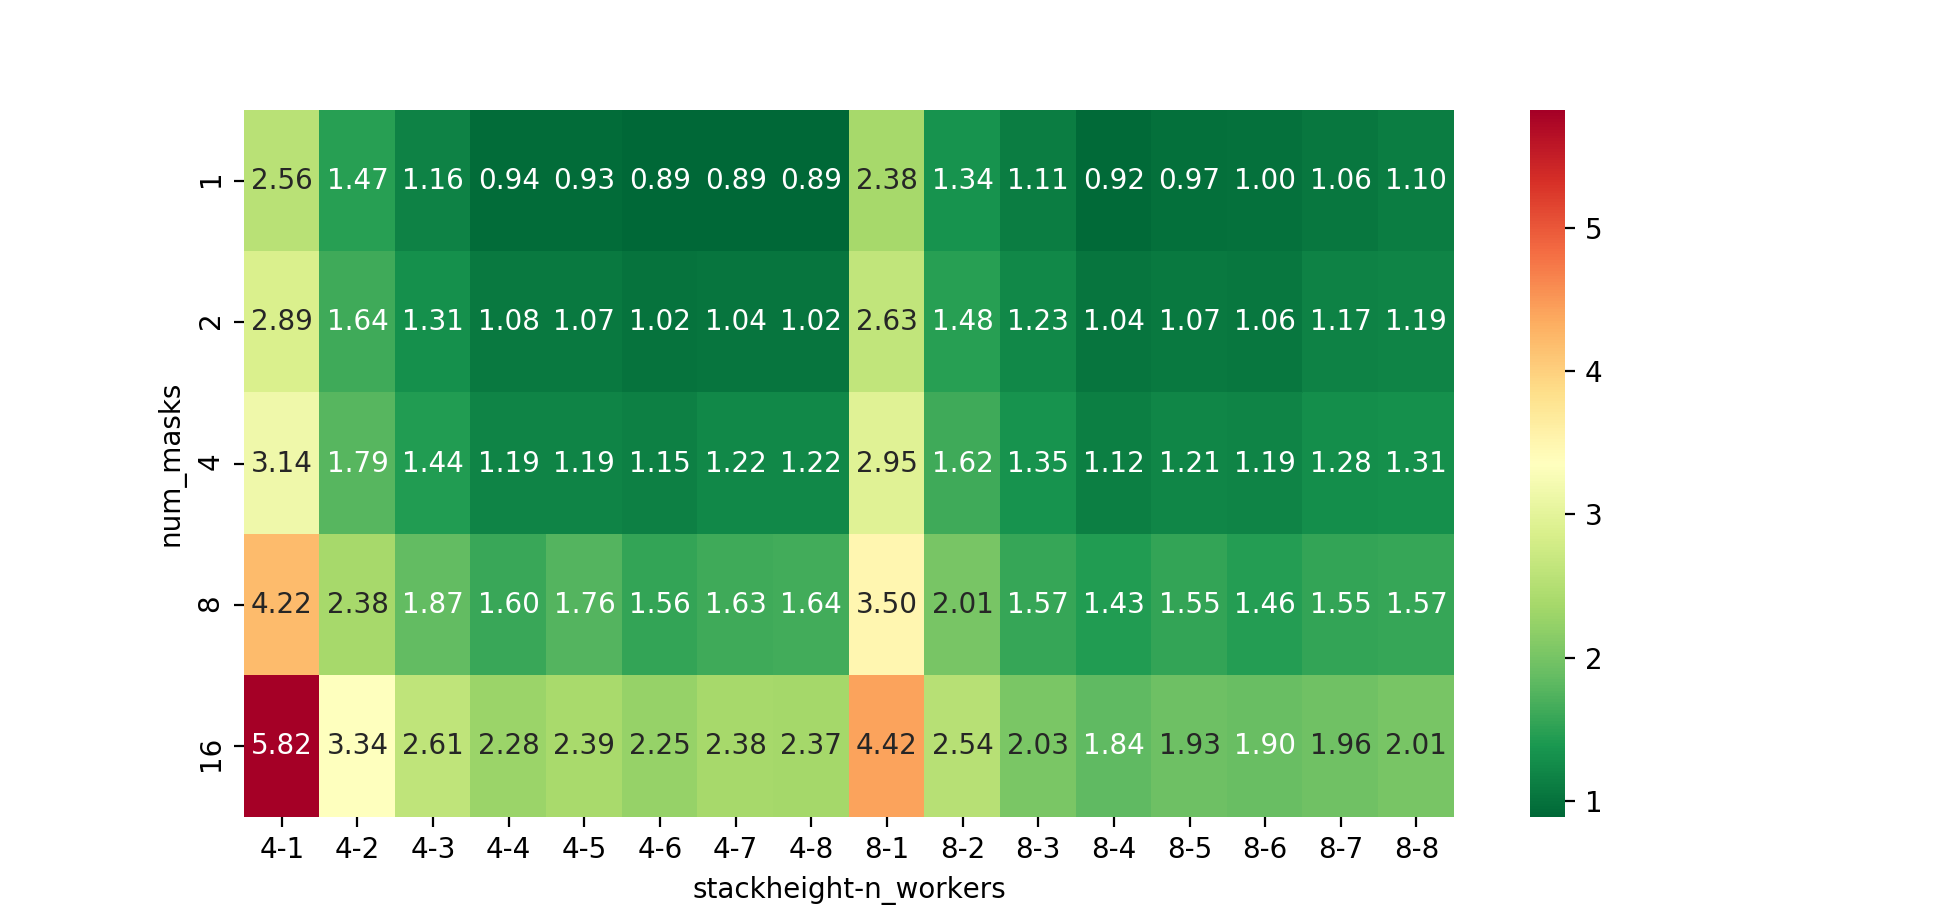

In [11]:
table = df.pivot_table(values='time', columns=['stackheight', "n_workers"], index=["num_masks"])
cmap = "RdYlGn_r"
seaborn.heatmap(table, annot=True, cmap=cmap, fmt=".2f")
plt.show()

<IPython.core.display.Javascript object>


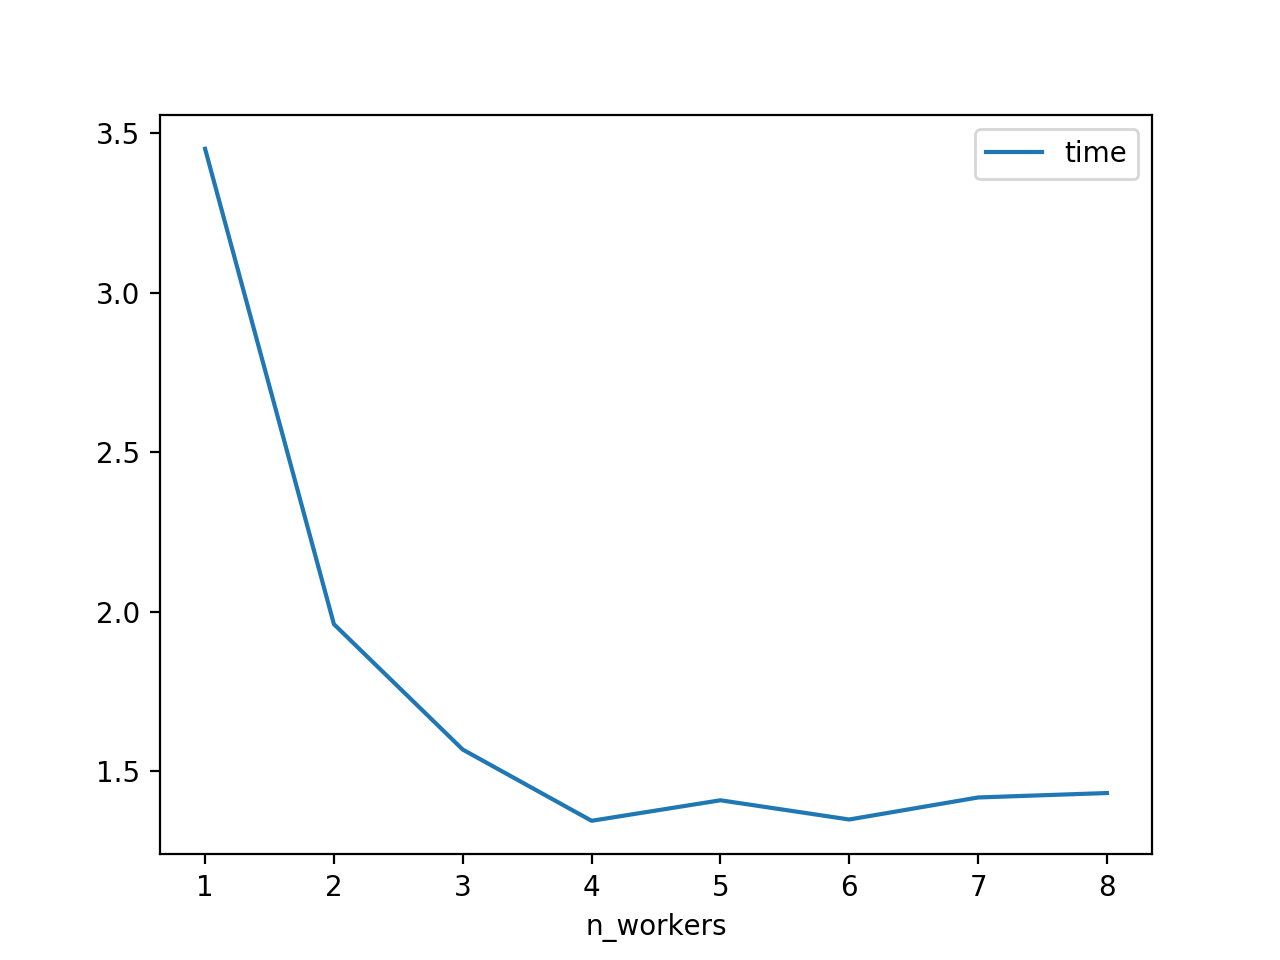

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [18]:
df.groupby(["n_workers"]).mean()[["time"]].plot()

In [30]:
df2 = pd.merge(
    df[df.stackheight == 4].groupby("n_workers")["n_workers", "time"].mean(),
    df[df.stackheight == 8].groupby("n_workers")["n_workers", "time"].mean(),
    on="n_workers",
)

In [26]:
df2

,n_workers,time_x,time_y
0,1,3.725856,3.175883
1,2,2.123179,1.797800
2,3,1.676922,1.457826
3,4,1.418348,1.269745
4,5,1.469158,1.347606
5,6,1.373891,1.322316
6,7,1.431285,1.403106
7,8,1.426761,1.435410


<IPython.core.display.Javascript object>


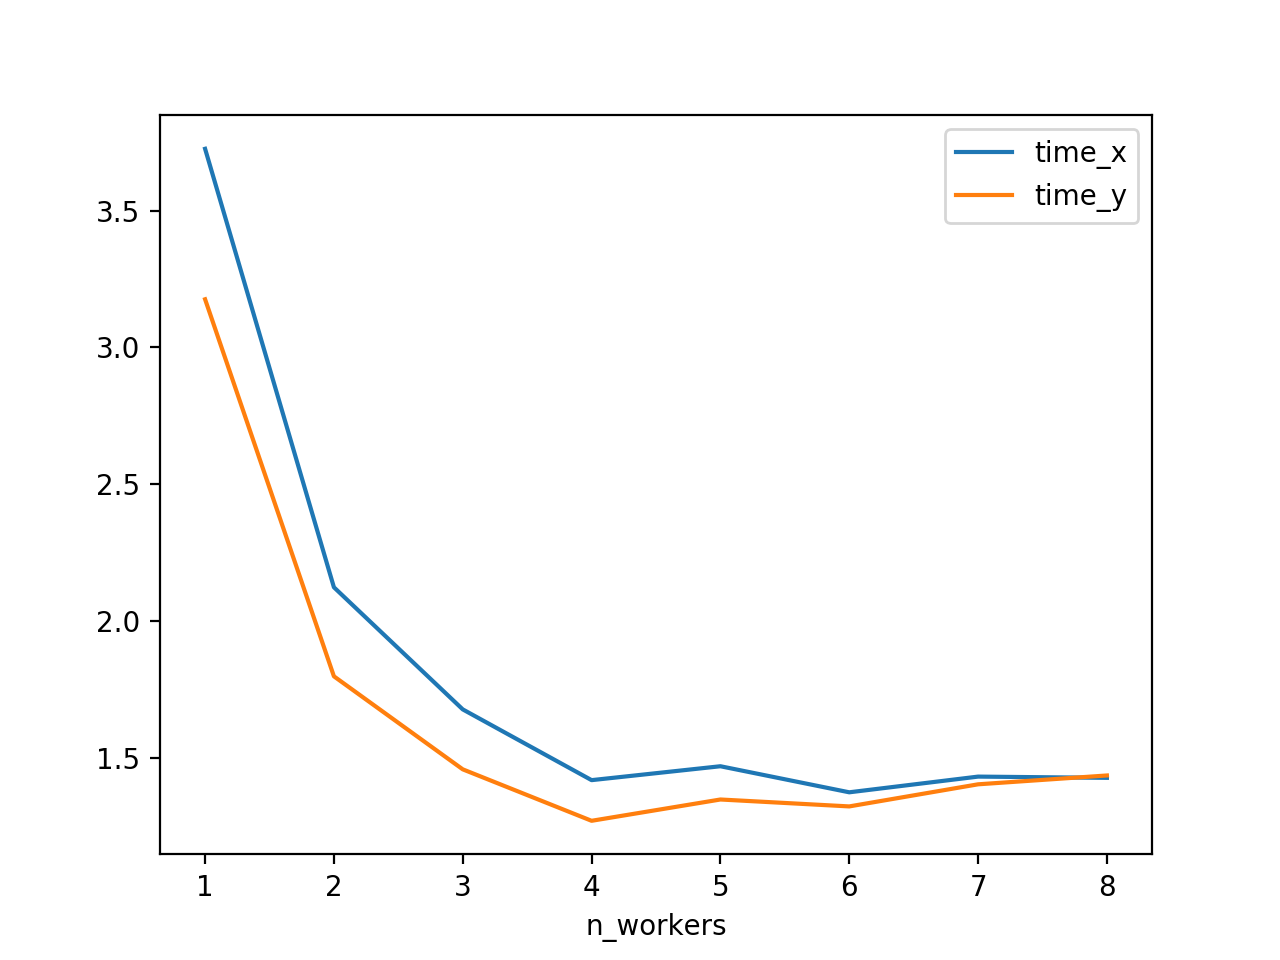

In [31]:
df2.set_index('n_workers').plot()

In [32]:
len(results)

240